Copyright 2023 The TensorFlow Authors.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFX Pipeline for Fine-Tuning and Converting an Large Language Model (LLM)

In this codelab, we use  KerasNLP to load a pre-trained Large Language Model (LLM) - GPT-2 model - and finetune it to a dataset. The dataset that is used in this demo is CNN daily dataset. After producing a finetuned model, the pipeline converts the model into a TFLite model, a machine learning model that has been converted into a format that can be run on mobile devices, and a quantized TFLite model, which is a more efficient version of a TFLite model as it represents the model's weights and activations using fewer bits.

## Why Is Pipeline Useful?
TFX pipelines are a valuable tool for building and managing machine learning workflows in a production environment. They are more reproducible, scalable, and modular than simply running pure Python code. This makes them ideal for working with large language models, which require a lot of compute resources and can be difficult to debug. TFX pipelines can also help you automate the finetuning and conversion process, which can save you a lot of time and effort.  

In addition to the benefits mentioned above, TFX pipelines can also help you track the lineage of your data and models using metadata. This means that you can easily see how your data and models were created and how they relate to each other. This can be helpful for debugging, auditing, and understanding the performance of your models.

## Note
Note that GPT-2 is used here only to demonstrate the end-to-end process; the techniques and tooling introduced in this codelab are potentially transferrable to other generative language models such as Google T5.

Note: We recommend running this tutorial in a Colab notebook, with no setup required!  Just click "Run in Google Colab".

<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/tfx/gpt2_fine_tuning_and_conversion">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png"/>View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/tfx/gpt2_fine_tuning_and_conversion.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/tree/master/docs/tutorials/tfx/gpt2_fine_tuning_and_conversion.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
<td><a href="https://storage.googleapis.com/tensorflow_docs/tfx/docs/tutorials/tfx/gpt2_fine_tuning_and_conversion.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td>
</table></div>

# Before You Begin

Colab offers different kinds of runtimes. Make sure to go to **Runtime -> Change runtime** type and choose the GPU Hardware Accelerator runtime (which should have >12G System RAM and ~15G GPU RAM) since you will finetune the GPT-2 model.

# Set Up

We first install required python packages.

## Upgrade Pip
To avoid upgrading Pip in a system when running locally, check to make sure that we are running in Colab. Local systems can of course be upgraded separately.

In [ ]:
try:
  import colab
  !pip install --upgrade pip

except:
  pass

## Install required libraries

In [ ]:
!pip install -U tfx

In [ ]:
!pip install git+https://github.com/keras-team/keras-nlp.git@google-io-2023 tensorflow-text==2.12 tensorflow_datasets more_itertools

## Uninstall shapely

TODO(b/263441833) This is a temporal solution to avoid an ImportError. Ultimately, it should be handled by supporting a recent version of Bigquery, instead of uninstalling other extra dependencies.


In [ ]:
!pip uninstall shapely -y

## Did you restart the runtime?

If you are using Google Colab, the first time that you run the cell above, you must restart the runtime by clicking above "RESTART RUNTIME" button or using "Runtime > Restart runtime ..." menu. This is because of the way that Colab loads packages. Check the TensorFlow and TFX versions.


In [ ]:
import tfx
from tensorflow import keras
from tfx.types import Channel

##Installing Interactive Context

An interactive context is used to provide global context when running a TFX pipeline in a notebook without using a runner or orchestrator such as Apache Airflow or Kubeflow. This style of development is only useful when developing the code for a pipeline, and cannot currently be used to deploy a working pipeline to production.

In [ ]:
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
context = InteractiveContext()

Let's check the library versions.

In [ ]:
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))

# Pipeline Overview

Below is a diagram that illustrates the pipeline that this Colab Notebook follows.

* **Artifacts** are data that is produced by a component or consumed by a component. Artifacts are stored in a system for managing the storage and versioning of artifacts.
* **Components** are defined as the implementation of an ML task that you can use as a step in your pipeline
* Aside from artifacts, **parameters** are passed into the components to specify an argument.


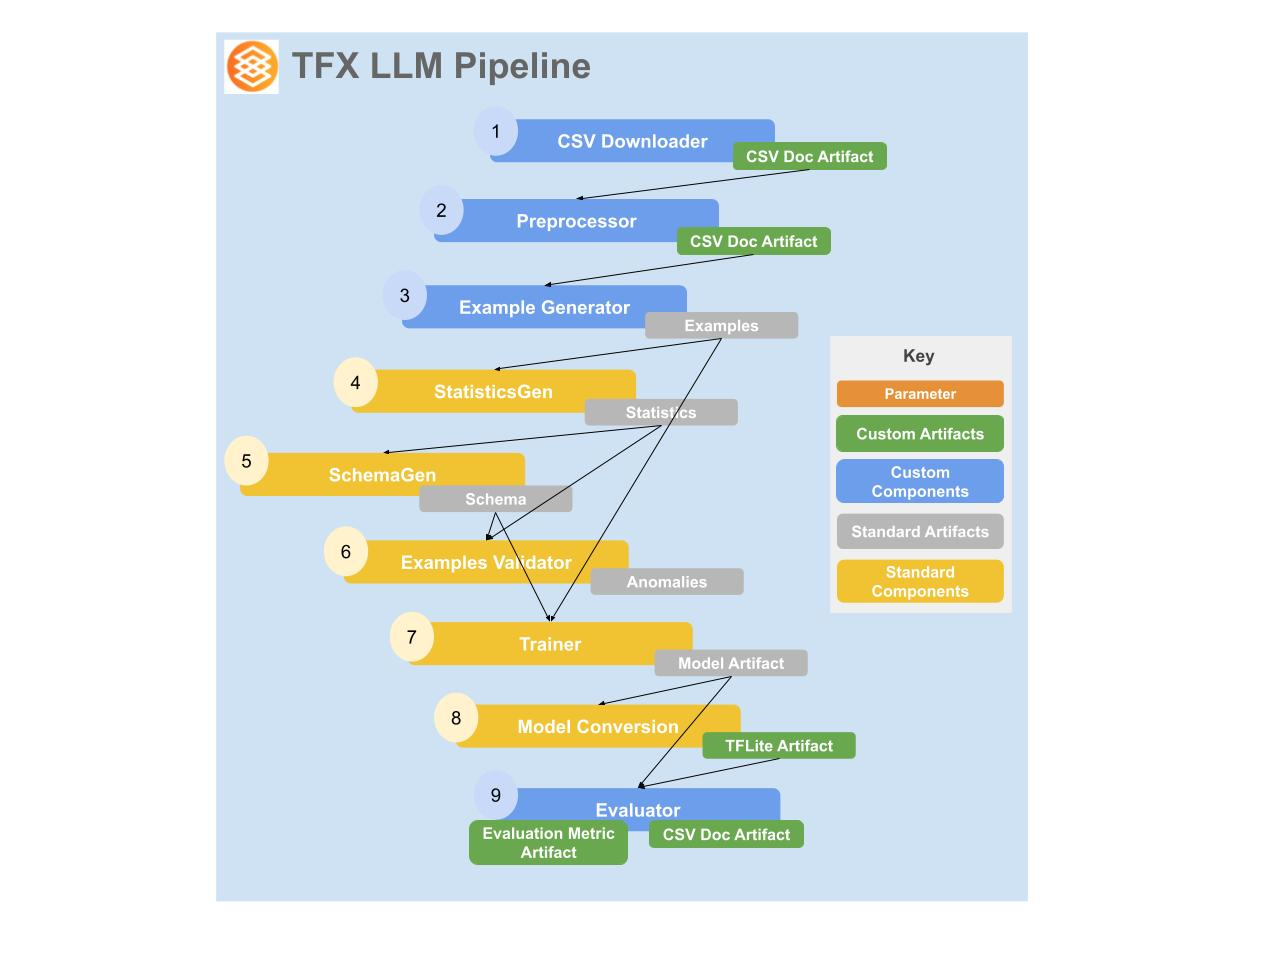

# CSV Downloader
In order to make the pipeline more efficient and possible for automation, it is useful to have a component that takes in a download link to the CSV file to be downloaded. Furthermore, one important goal of TFX production ML pipeline is to collect metadata containing information about the pipeline components, their executions, and resulting artifacts. In other words, the purpose of the metadata is to analyze the lineage of pipeline components and debug issues, and the CSV Downloader Component would help the users logging and tracking information about the source of the data and the preprocessing steps that the data have undergone before entering the pipeline. In this section, we declare a new artifact called CSVdoc and develop a custom component (CSV Downloader) which stores information about the dataset and downloads the CSV file in the CSVdoc artifact's URI.

In [ ]:
from tfx import types
from tfx.types import artifact

Property = artifact.Property
PropertyType = artifact.PropertyType
PropertyType = artifact.PropertyType

URL_PROPERTY = Property(type=PropertyType.STRING)
PATH_PROPERTY = Property(type=PropertyType.STRING)


class CsvDoc(types.Artifact):
  """Artifact that contains the CSV dataset.

  - 'url' : saves the source of the original data.
  - 'path': saves the path to the CSV file.
  """

  TYPE_NAME = 'CsvDoc'
  PROPERTIES = {
      'url': URL_PROPERTY,
      'path': PATH_PROPERTY,
  }

In [ ]:
import os
from absl import logging
import requests


@tfx.dsl.components.component
def CsvDownloaderComponent(
    url: tfx.dsl.components.Parameter[str],
    file_name: tfx.dsl.components.Parameter[str],
    saved_file: tfx.dsl.components.OutputArtifact[CsvDoc],
) -> None:
  """Downloads a csv file from a url and saves the result to a CSVfile.

  Args:
    url: Link for downloading the desired CSV file.
    file_name: Name of the downloaded CSV file.

  Raises:
    ValueError: If the CSV file failed to be downloaded.
  """
  response = requests.get(url)
  saved_file.url = url
  if response.status_code == 200:
    file_path = os.path.join(saved_file.uri, file_name)
    saved_file.path = file_path
    url_content = response.content
    with open(file_path, 'wb') as csv_file:
      csv_file.write(url_content)
    logging.info(f'CSV file saved successfully at {file_path}')
  else:
    raise ValueError('CSV file failed to be saved.')

## About CNN DailyMail Dataset
 **CNN/DailyMail dataset** is a large English-language dataset of news articles that can be used for both extractive and abstractive summarization. The original version was created for machine reading comprehension and abstractive question answering, but the current version supports both tasks.

In this tutorial, the url provided in the cell below is the trimmed version of [Kaggle](https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail)'s train dataset. This link is a direct download link to the dataset.

In [ ]:
downloader = CsvDownloaderComponent(
    url='https://drive.google.com/uc?id=1YdZsJlRafqxiNSl0nHQkwR7rzrNlN9LI&export=download',
    file_name='all.csv',
)

In [ ]:
context.run(downloader, enable_cache=False)

# Preprocessor

As a second component of the LLM pipeline, this component takes in a CSV artifact as its input and ouputs a CsvDoc artifact, a custom artifact created in the previous step. We apply NLTK Tokenizer in this step as well to tokenize a single long text into a list of tokenized sentences.

First, let's install nltk, package with the sentence tokenizer 'punkt'.

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
from typing import Sequence
from nltk import tokenize
import pandas as pd


def merge_sentences(sentences: Sequence, max_length: int) -> list:
  """Merge individual sentences into longer context.

  Args:
    sentences: List of texts from training file.
    max_length: Maximum length to which the sentences will be merged up to.

  Returns:
    List of preprocessed texts.
  """
  res = []
  cur_len = 0
  cur_sentences = []
  for s in sentences:
    if cur_len + len(s) > max_length:
      res.append(" ".join(cur_sentences))
      cur_len = len(s)
      cur_sentences = [s]
    else:
      cur_len += len(s)
      cur_sentences.append(s)
  res.append(" ".join(cur_sentences))
  return res


def preprocess(articles: Sequence) -> list:
  """Preprocesses training texts and returns preprocessed texts in a dataframe.

  Args:
    articles: Sequence of articles for training.

  Returns:
    List of preprocessed texts.
  """
  all_sentences = []
  num_articles_to_process = 500
  max_length = 512
  for i in range(min(len(articles), num_articles_to_process)):
    # Use NLTK tokenize to split articles into sentences
    sentences = tokenize.sent_tokenize(str(articles[i]))
    # Merge individual sentences into longer context
    combined_res = merge_sentences(sentences, max_length)
    # Add merged context into collection
    all_sentences.extend(combined_res)
  return all_sentences


@tfx.dsl.components.component
def Preprocessor(
    saved_file: tfx.dsl.components.InputArtifact[CsvDoc],
    preprocessed_file: tfx.dsl.components.OutputArtifact[CsvDoc],
) -> None:
  """Preprocesses texts from the dataset into a list of sentences.

  Loads a CSV document from the CSV artifact, output from the CSV downloader
  component, and preprocesses it into a list of sentences. It then generates
  a CSV containing preprocessed texts.

  Args:
    saved_file: CsvDoc artifact containing text data that will be used for
      training.
  """
  with open(saved_file.path, "r") as f:
    df = pd.read_csv(f, delimiter=",")
  preprocessed_text = preprocess(df["article"])
  column_value = "preprocessed_text"
  preprocessed_df = pd.DataFrame(data=preprocessed_text, columns=[column_value])
  preprocessed_path = f"{preprocessed_file.uri}/processed_data.csv"
  preprocessed_file.path = preprocessed_path
  preprocessed_df.to_csv(preprocessed_path, index=False)

In [ ]:
preprocessor = Preprocessor(saved_file=downloader.outputs["saved_file"])

In [ ]:
context.run(preprocessor, enable_cache=False)

# ExampleGenerator

In the CustomExampleGen component, we will create a standard Examples artifact. With this standard Examples artifact, we can use standard components, such as StatisticsGen, SchemaGen, and Example_Validator.

The code for CustomExampleGen demonstrates how to *incorporate custom components and artifacts with standard artifacts*. As this LLM pipeline illustrates, standard components and artifacts *might not be the best way* to perform each step of MLOPS process. For example, in this tutorial, we needed a preprocessing component before the exampleGen to preprocess the raw texts that have not been transformed into tensors. Therefore, it is *useful* to know how to incorporate standard artifacts with custom components and artifacts.


The cell below contains helper functions for generating standard Examples artifact. The standard Examples artifact expects train and test data, and therefore, the function *'split data'* creates a test and training data.
The function *'write_examples'* writes a file into TFRecords format because within the pipeline, when the TFX components are sequentially executed, the data in between components are shared in **TFRecord format**.


In [ ]:
import csv
import os
import random
from typing import List
import tensorflow as tf
import tfx.v1 as tfx

random.seed(10)


def split_data(dir: str, train_fraction: float):
  """Splits the data in the CSV file into a training set and a test set.

  Args:
    dir: The directory to the CSV file to be splitted into test and training.
    train_fraction: The fraction of the data to use for the training set.

  Returns:
    A tuple of the training data and the test data.
  """
  with open(dir, "r") as f:
    reader = csv.reader(f)
    data = list(reader)[1:]

  random.shuffle(data)
  train_size = int(len(data) * train_fraction)
  train_data = data[:train_size]
  flatten_train_data = [item for items in train_data for item in items]

  test_data = data[train_size:]
  flatten_test_data = [item for items in test_data for item in items]

  return flatten_train_data, flatten_test_data


def write_examples(path_to_file: str, data: List[str]) -> None:
  """Saves a file in TFRecord format.

  Takes a path to a file and a list of strings as input, and writes the strings
  to the file in TFRecord format.

  Args:
    path_to_file: The path to the file to write the examples to.
    data: A list of strings to write to the file.
  """
  with tf.io.TFRecordWriter(
      os.path.join(path_to_file, "tfrecord_doc.tfrecord")
  ) as writer_train:
    for article in data:
      example = tf.train.Example()
      features = example.features.feature
      features["article"].bytes_list.value.append(article.encode("utf-8"))
      writer_train.write(example.SerializeToString())

In [ ]:
@tfx.dsl.components.component
def CustomExampleGen(
    input_csv: tfx.dsl.components.InputArtifact[CsvDoc],
    examples: tfx.dsl.components.OutputArtifact[
        tfx.types.standard_artifacts.Examples
    ],
    training_fraction: float = 0.74,
) -> None:
  path_to_train = os.path.join(examples.uri, "Split-train")
  path_to_test = os.path.join(examples.uri, "Split-test")
  train_data, test_data = split_data(
      os.path.join(input_csv.uri, "processed_data.csv"), training_fraction
  )
  if os.path.exists(path_to_train):
    os.rmdir(path_to_train)
  if os.path.exists(path_to_test):
    os.rmdir(path_to_test)
  os.mkdir(path_to_train)
  os.mkdir(path_to_test)
  write_examples(path_to_train, train_data)
  write_examples(path_to_test, test_data)

  examples.split_names = '["train", "test"]'

In [ ]:
example_gen = CustomExampleGen(
    input_csv=preprocessor.outputs['preprocessed_file']
)

In [ ]:
context.run(example_gen, enable_cache=False)

Now that we have standard Exmaples artifact, we can pass it as an input for StatisticsGen, SchemaGen, and ExampleValidator, which are components that are useful for preparing data and understanding their properties / characteristics.

# Statistics Generator

**StatisticsGen** generates statistics about the data, such as the number of examples, the number of features, and the data types of the features.

Note that the statistics generator is appropriate for tabular data, and therefore, text dataset for this LLM tutorial may not be the optimal dataset for the analysis with statistics generator.

In [ ]:
from tfx.components import StatisticsGen

In [ ]:
statistics_gen = tfx.components.StatisticsGen(
    examples=example_gen.outputs['examples'], exclude_splits=['eval']
)
context.run(statistics_gen, enable_cache=False)

In [ ]:
context.show(statistics_gen.outputs['statistics'])

# SchemaGen

SchemaGen infers a schema from the data. A schema is a description of the data, which includes the names of the features, the data types of the features, and any other constraints on the data.


In [ ]:
schema_gen = tfx.components.SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=False,
    exclude_splits=['eval'],
)
context.run(schema_gen, enable_cache=False)

In [ ]:
context.show(schema_gen.outputs['schema'])

# ExampleValidator

ExampleValidator validates the data against the schema and ensures that the data are consistent and consistent.

In [ ]:
example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'],
    exclude_splits=['eval'],
)
context.run(example_validator, enable_cache=False)

In [ ]:
context.show(example_validator.outputs['anomalies'])

# Trainer

Trainer component trains an ML model, and it requires a model definition code from users.

The run_fn function in TFX's Trainer component is the entry point for training a machine learning model. It is a user-supplied function that takes in a set of arguments and returns a model artifact.

The run_fn function is responsible for:

*   Building the machine learning model.
*   Training the model on the training data.
*   Saving the trained model to the serving model directory.


## Write model training code
You will create a very simple fine-tuned model, with the preprocessing GPT-2 model. First, we need to create a module that contains the run_fn function for TFX Trainer because TFX Trainer expects the run_fn function to be defined in a module.  

In [ ]:
!mkdir modules

In [ ]:
model_file = "modules/model.py"
model_fn = "modules.model.run_fn"

Now, we write the run_fn function:

This run_fn function first gets the training data from the fn_args.examples argument. It then gets the schema of the training data from the fn_args.schema argument. Next, it loads finetuned GPT-2 model along with its preprocessor. The model is then trained on the training data using the model.train() method.
Finally, the trained model is saved to the fn_args.serving_model_dir argument.


Now, we are going to work with Keras NLP's GPT-2 Model! You can learn about the full GPT-2 model implementation in KerasNLP on [GitHub]((https://github.com/keras-team/keras-nlp/blob/master/keras_nlp/models/gpt2/) or can read (and interactively test the model) on [Google IO2023 colab notebook](https://colab.research.google.com/github/tensorflow/codelabs/blob/main/KerasNLP/io2023_workshop.ipynb#scrollTo=81EZQ0D1R8LL ).


In [ ]:
import keras_nlp
from tensorflow import keras
import tensorflow as tf

In [ ]:
%%writefile {model_file}

import os
import time
from absl import logging
import keras_nlp
import more_itertools
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tfx
import tfx.components.trainer.fn_args_utils


_EPOCH = 1
_BATCH_SIZE = 20
_INITIAL_LEARNING_RATE = 5e-5
_END_LEARNING_RATE = 0.0


def _input_fn(file_pattern: str) -> list:
  """Retrieves training data and returns a list of articles for training.

  For each row in the TFRecordDataset, generated in the previous ExampleGen
  component, create a new tf.train.Example object and parse the TFRecord into
  the example object. Articles, which are initially in bytes objects, are
  decoded into a string.

  Args:
    file_pattern: Path to the TFRecord file of the training dataset.

  Returns:
    A list of training articles.

  Raises:
    FileNotFoundError: If TFRecord dataset is not found in the file_pattern
    directory.
  """
  if os.path.basename(file_pattern) == '*':
    file_path = os.path.join(
        os.path.dirname(file_pattern), 'tfrecord_doc.tfrecord'
    )
  else:
    raise FileNotFoundError(
        f"There is no file in the current directory: '{file_pattern}."
    )
  train_articles = []
  parsed_dataset = tf.data.TFRecordDataset([file_path])
  for raw_record in parsed_dataset:
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    train_articles.append(
        example.features.feature['article'].bytes_list.value[0].decode('utf-8')
    )
  return train_articles

def run_fn(fn_args: tfx.components.trainer.fn_args_utils.FnArgs) -> None:
  """Trains the model and outputs the trained model to a the desired location given by FnArgs.

  Args:
    FnArgs :  Args to pass to user defined training/tuning function(s)
  """

  train_articles =  pd.Series(_input_fn(
          fn_args.train_files[0],
      ))
  tf_train_ds = tf.data.Dataset.from_tensor_slices(train_articles)

  gpt2_preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
      'gpt2_base_en',
      sequence_length=256,
      add_end_token=True,
  )
  gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset(
      'gpt2_base_en', preprocessor=gpt2_preprocessor
  )

  processed_ds = (
      tf_train_ds.map(gpt2_preprocessor, tf.data.AUTOTUNE)
      .batch(_BATCH_SIZE)
      .cache()
      .prefetch(tf.data.AUTOTUNE)
  )

  gpt2_lm.include_preprocessing = False

  lr = tf.keras.optimizers.schedules.PolynomialDecay(
      5e-5,
      decay_steps=processed_ds.cardinality() * _EPOCH,
      end_learning_rate=0.0,
  )
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  gpt2_lm.compile(
      optimizer=keras.optimizers.experimental.Adam(lr),
      loss=loss,
      weighted_metrics=['accuracy'],
  )

  gpt2_lm.fit(processed_ds, epochs=_EPOCH)
  if os.path.exists(fn_args.serving_model_dir):
    os.rmdir(fn_args.serving_model_dir)
  os.mkdir(fn_args.serving_model_dir)
  gpt2_lm.backbone.save_weights(
      filepath=os.path.join(fn_args.serving_model_dir, "model_weights"), save_format='tf'
  )

In [ ]:
trainer = tfx.components.Trainer(
    run_fn=model_fn,
    examples=example_gen.outputs['examples'],
    train_args=tfx.proto.TrainArgs(splits=['train']),
    eval_args=tfx.proto.EvalArgs(splits=['train']),
    schema=schema_gen.outputs['schema'],
)

In [ ]:
context.run(trainer, enable_cache=False)

# TFLite Conversion  

We can convert the pretrained model into a TFLite model, which is a specific type of model that is designed to be used on mobile and embedded devices.
TFLite models are smaller and faster than their TensorFlow counterparts, making them ideal for use on devices with limited resources.

We can optimize the model using quantization. TensorFlow Lite can be used to shrink down the model size and accelerate model inference by mapping an input of continuous values to a discrete set.

In this workshop you will use the [post-training dynamic range quantization](https://www.tensorflow.org/lite/performance/post_training_quant) by setting the converter optimization flag to 'tf.lite.Optimize.DEFAULT'. The rest of the conversion process is the same as before.

If you are interested in how TFLite works and would like to interactively work with it on colab notebook, you can explore this [Google IO2023 Colab Notebook](https://colab.research.google.com/github/tensorflow/codelabs/blob/main/KerasNLP/io2023_workshop.ipynb#scrollTo=ZVrW3jyVNEH9)

We will first create a TFLite artifact in order to save the TFLite model.

In [ ]:
from tfx import types
from tfx.types import artifact
from enum import Enum

Property = artifact.Property
PropertyType = artifact.PropertyType


DURATION_PROPERTY = Property(type=PropertyType.FLOAT)
EPOCH_PROPERTY = Property(type=PropertyType.INT)
SIZE_PROPERTY = Property(type=PropertyType.INT)
QUANTIZED_PROPERTY = Property(type=PropertyType.STRING)

class TFLite(types.Artifact):
  """Artifact that contains the trained model.

  * Properties:
    - `epoch`: The number of epochs it took to train the model.
    - `model_size`: The size of the model
    - `train_duration`: The total time elapsed for training and saving
       the model in seconds.
    - `is_quantized`: A boolean value indicating whether the model is the
       quantized TFLite model or not.
  """

  TYPE_NAME = 'TFLite'
  PROPERTIES = {
      'epoch': EPOCH_PROPERTY,
      'model_size': SIZE_PROPERTY,
      'conversion_duration': DURATION_PROPERTY,
      'is_quantized': QUANTIZED_PROPERTY,
        }

We have to initialize the gpt-2 model to ensure that we are working with a base model.

In [ ]:
gpt2_tokenizer = keras_nlp.models.GPT2Tokenizer.from_preset("gpt2_base_en")
gpt2_preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=256,
    add_end_token=True,
)
gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset("gpt2_base_en", preprocessor=gpt2_preprocessor)

First, you wrap the generate() function into a TensorFlow concrete function. The @tf.function decorator is used to convert a Python function to a TensorFlow graph function. This can improve the performance of the function by optimizing the TensorFlow operations that are executed.


In [ ]:
@tf.function
def generate(prompt, max_length):
    return gpt2_lm.generate(prompt, max_length)

concrete_func = generate.get_concrete_function(tf.TensorSpec([], tf.string), 100)

In [ ]:
"""A Conversion Component that transforms a trained model into TFLite Model.
This is a conversion component that the users can specify whether the model will
be quantized or not.
"""
import time


@tfx.dsl.components.component
def Conversion(
    trained_model: tfx.dsl.components.InputArtifact[tfx.types.standard_artifacts.Model],
    tflite_model: tfx.dsl.components.OutputArtifact[TFLite],
    is_quantized: tfx.dsl.components.Parameter[bool]) -> None:

    # Creating a tflite model for generate function
    start = time.time()
    trained_model_dir = os.path.join(trained_model.uri,'Format-Serving', 'model_weights')
    gpt2_lm.load_weights(trained_model_dir)
    gpt2_lm.jit_compile = False
    generate_converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func],
                                                            gpt2_lm)
    generate_converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
        tf.lite.OpsSet.SELECT_TF_OPS,  # enable TensorFlow ops.
    ]
    generate_converter.allow_custom_ops = True
    if is_quantized:
      generate_converter.optimizations = [tf.lite.Optimize.DEFAULT]

    generate_converter.target_spec.experimental_select_user_tf_ops = [
        "UnsortedSegmentJoin",
        "UpperBound",

    ]
    generate_converter._experimental_guarantee_all_funcs_one_use = True
    generate_tflite = generate_converter.convert()
    end = time.time()
    generate_path = os.path.join(tflite_model.uri, "quantized_gpt2_generate.tflite")
    with open(generate_path, "wb") as f:
      f.write(generate_tflite)
    # tflite_model.conversion_duration = end - start
    # tflite_model.model_size = os.path.getsize(generate_path)


    # Creating a tflite model for Runner (needed for calculating perplexity)
    runner_converter = tf.lite.TFLiteConverter.from_keras_model(gpt2_lm)
    if is_quantized:
      runner_converter.optimizations = [tf.lite.Optimize.DEFAULT]
    runner_converter.target_spec.supported_ops = [
      tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
      tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
    ]
    runner_converter.allow_custom_ops = True
    runner_converter.target_spec.experimental_select_user_tf_ops = ["UnsortedSegmentJoin", "UpperBound"]
    runner_converter._experimental_guarantee_all_funcs_one_use = True

    runner_tflite = runner_converter.convert()
    runner_path = os.path.join(tflite_model.uri, "quantized_gpt2_runner.tflite")
    with open(runner_path, "wb") as f:
      f.write(runner_tflite)

    if is_quantized:
      tflite_model.is_quantized = "QUANTIZED"
    else:
      tflite_model.is_quantized = "UNQUANTIZED"

Similarly, let's convert the trained model into a TFLite model by running the Conversion component with parameter 'is_quantized' specified to False.

In [ ]:
tflite_model = Conversion(trained_model = trainer.outputs['model'], is_quantized = False)

In [ ]:
context.run(tflite_model, enable_cache = False)

Let's convert the trained model into a Quantized TFLite model by running the Conversion component with parameter 'is_quantized' specified to True.

In [ ]:
quantized_model = Conversion(trained_model = trainer.outputs['model'], is_quantized = True)

In [ ]:
context.run(quantized_model, enable_cache = False)

# Inference and Evaluation

Now that we have fine-tuned the model and converted them to a TFlite model, let's test these models to make inferences. We will create a EvaluationMetric artifact since we want to save the inference results.


In [ ]:
from tfx.types import artifact
from tfx import types

Property = artifact.Property
PropertyType = artifact.PropertyType

DURATION_PROPERTY = Property(type=PropertyType.FLOAT)
EVAL_OUTPUT_PROPERTY = Property(type=PropertyType.STRING)

class EvaluationMetric(types.Artifact):
  """Artifact that contains metrics for a model.

  * Properties:

     - 'model_prediction_time' : time it took for the model to make predictions
     based on the input text.
     - 'model_evaluation_output_path' : saves the path to the CSV file that
     contains the model's prediction based on the testing inputs.
  """

  TYPE_NAME = 'Evaluation_Metric'
  PROPERTIES = {
      'model_prediction_time': DURATION_PROPERTY,
      'model_evaluation_output_path': EVAL_OUTPUT_PROPERTY,
  }

Here, we are defining a helper function to run inference with a given input and a TFLite model. Note that here TensorFlow Text ops are registered as custom ops so that the interpreter can run smoothly.


In [ ]:
from tensorflow.lite.python import interpreter
import tensorflow_text as tf_text
def run_inference(input, model):
  interp = interpreter.InterpreterWithCustomOps(
      model_content=model,
      custom_op_registerers=tf_text.tflite_registrar.SELECT_TFTEXT_OPS)
  interp.get_signature_list()

  generator = interp.get_signature_runner('serving_default')
  output = generator(prompt=np.array([input]))
  output_text = output["output_0"].item(0).decode('utf-8')
  return output_text

In order to produce logits with TFLite models, we need to create a separate interpreter such that takes in a TFLite model as input and returns an object defined as "runner" that we need later for comupting perplexity for tflite models.


The function first creates an interpreter.InterpreterWithCustomOps object, which is a specialized interpreter that can run TFLite models that use custom TensorFlow ops. The interpreter.InterpreterWithCustomOps object is then configured to use the TFText ops.

Next, the function resizes the input tensors to the specified size. This is necessary because the default size of input tensors in TFLite models is [1,1]. Finally, the function allocates the tensors in the interpreter and gets the signature list.

In [ ]:
from tensorflow.lite.python import interpreter
def create_runner(tflite_model):
  interp = interpreter.InterpreterWithCustomOps(
      model_content=tflite_model,
      custom_op_registerers=tf_text.tflite_registrar.SELECT_TFTEXT_OPS)

  # Need to resize tensor inputs or they will be [1,1]!
  interp.resize_tensor_input(0, (1,255))
  interp.resize_tensor_input(1, (1,255))
  interp.allocate_tensors()

  interp.get_signature_list()
  runner = interp.get_signature_runner('serving_default')
  return runner

Below are some helper functions for calculating perplexity, a measure of how well a language model predicts the next word in a sequence. It is calculated by taking the exponential of the negative log likelihood of the observed sequence. A lower perplexity score indicates that the model is more confident in its predictions, which makes it more likely that the model will perform better.


In [ ]:
"""This is an evaluation component for the LLM pipeline takes in a

standard trainer artifact and outputs a custom evaluation artifact.
It displays the evaluation output in the colab notebook.
"""
import os
import time
from typing import Optional
from IPython import display
import keras_nlp
import numpy as np
import pandas as pd
import tensorflow as tf
import tfx.v1 as tfx

_TEST_SIZE = 2
_INPUT_LENGTH = 25


def input_fn(file_pattern: str) -> list:
  """Retrieves training data and returns a list of articles for training.

  Args:
    file_pattern: Path to the TFRecord file of the training dataset.

  Returns:
    A list of test articles

  Raises:
    FileNotFoundError: If the file path does not exist.
  """
  file_path = os.path.join(file_pattern, 'tfrecord_doc.tfrecord')
  if os.path.exists(file_path):
    test_articles = []
    parsed_dataset = tf.data.TFRecordDataset([file_path])
    for raw_record in parsed_dataset:
      example = tf.train.Example()
      example.ParseFromString(raw_record.numpy())
      test_articles.append(
          example.features.feature['article']
          .bytes_list.value[0]
          .decode('utf-8')
      )
    return test_articles
  else:
    raise FileNotFoundError(f'File path "{file_path}" does not exist.')


def trim_sentence(sentence: str, max_words: int = 20):
  """Trims the sentence to include up to the given number of words.

  Args:
    sentence: The sentence to trim.
    max_words: The maximum number of words to include in the trimmed sentence.

  Returns:
    The trimmed sentence.
  """
  words = sentence.split(' ')
  if len(words) <= max_words:
    return sentence
  return ' '.join(words[:max_words])

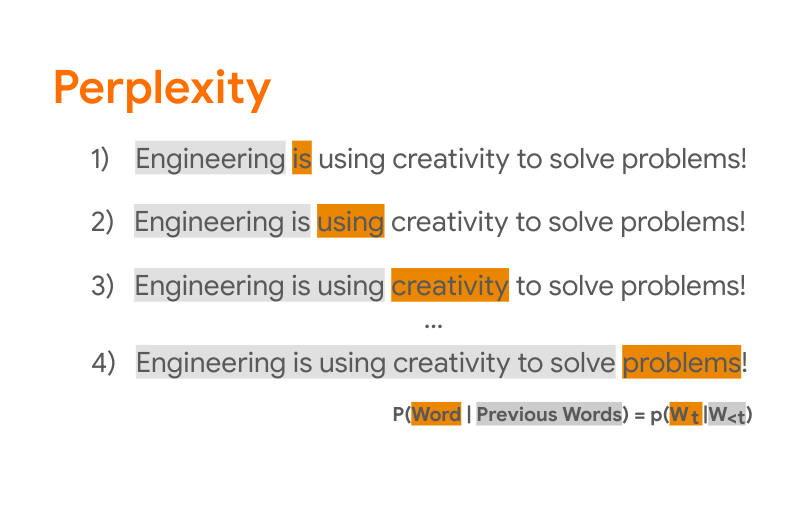

One of the useful metrics for evaluating a Large Language Model is **Perplexity**.

Perplexity is a measure of how well a language model predicts the next token in a sequence. It is calculated by taking the exponentiation of the average negative log-likelihood of the next token. A lower perplexity score indicates that the language model is better at predicting the next token.

This is the *formula* for calculating perplexity.

 $\text{Perplexity} = \exp(-1 * $ Average Negative Log Likelihood $) =
  \exp\left(-\frac{1}{T} \sum_{t=1}^T \log p(w_t | w_{<t})\right)$.


If you would like to explore how perplexity metrics work, you experiment on this[ colab notebook](https://colab.research.google.com/drive/18LKpcCwvQtfo_TbG2iMI3ru2QQ0HcQGp?usp=sharing)! You can experiment with computing perplexity for both base GPT-2 model and converted TFLite model.

In this colab notebook, we calculate perplexity using [Keras_nlp's perplexity](https://keras.io/api/keras_nlp/metrics/perplexity/).

**Computing Perplexity for Base GPT-2 Model and Finetuned Model**

The code below is the function will be used later in the notebook for computing perplexity for the base GPT-2 model and the finetuned model.

In [ ]:
def calculate_perplexity(gpt_model, sentence) -> int:
  """Calculates perplexity of a model given a sentence.

  Args:
    gpt_model: GPT-2 Language Model
    sentence: Sentence that the model's perplexity is calculated upon.

  Returns:
    A perplexity score.
  """
  gpt2_preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
      'gpt2_base_en',
      sequence_length=256,
      add_end_token=True,
  )
  gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset(
      'gpt2_base_en', preprocessor=gpt2_preprocessor
  )
  gpt2_tokenizer = keras_nlp.models.GPT2Tokenizer.from_preset('gpt2_base_en')
  # gpt2_tokenizer([sentence])[0] produces a tensor containing an array of tokens that form the sentence.
  tokens = gpt2_tokenizer([sentence])[0].numpy()
  # decoded_sentences is an array containing sentences that increase by one token in size.
  # e.g. if tokens for a sentence "I love dogs" are ["I", "love", "dogs"], then decoded_sentences = ["I love", "I love dogs"]
  decoded_sentences = [gpt2_tokenizer.detokenize([tokens[:i]])[0].numpy() for i in range(1, len(tokens))]
  predictions = gpt2_lm.predict(decoded_sentences)
  logits = [predictions[i - 1][i] for i in range(1, len(tokens))]
  target = tokens[1:].reshape(len(tokens) - 1, 1)
  perplexity = keras_nlp.metrics.Perplexity(from_logits=True)
  perplexity.update_state(target, logits)
  result = perplexity.result()
  return result.numpy()

def average_perplexity(gpt_model, gpt2_tokenizer, sentences):
  perplexity_lst = [calculate_perplexity(gpt_model, sent) for sent in sentences]
  return np.mean(perplexity_lst)


**Computing Perplexity for TFLite Models**

Similar to the code above for calculating perplexity for the base model and finetuned GPT-2 model, we also write a function that computes perplexity for TFlite models.

In [ ]:
def calculate_perplexity_tflite(sentence, runner) -> int:
  """Calculates perplexity of a TfLite model given a sentence.

  Args:
    sentence: Sentence that the model's perplexity is calculated upon.
    runner: Object that can be used to run the TensorFlow model's serving_default signature.

  Returns:
    A perplexity score.
  """

  gpt2_tokenizer = keras_nlp.models.GPT2Tokenizer.from_preset('gpt2_base_en')
  logits = []
  tokens = gpt2_tokenizer([sentence])[0].numpy()
  for i in range(1, len(tokens)):
    ds = tf.data.Dataset.from_tensor_slices([sentence])
    gpt2_preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
        "gpt2_base_en",
        sequence_length=256,
        add_end_token=True,
    )
    preprocessed_ds = ds.map(gpt2_preprocessor)
    _, token_ids, padding_mask = next(iter(preprocessed_ds))
    tflite_result = runner(token_ids=tf.expand_dims(token_ids, axis=0), padding_mask=tf.expand_dims(tf.cast(padding_mask, tf.int32), axis=0))
    prediction_key = list(tflite_result.keys())[0]
    tflite_prediction = tflite_result[prediction_key]
    logit = tflite_prediction[0][i]
    logits.append(logit)
  target = tokens[1:].reshape(len(tokens) - 1, 1)
  perplexity = keras_nlp.metrics.Perplexity(from_logits=True)
  perplexity.update_state(target, logits)
  result = perplexity.result()
  return result.numpy()

def average_perplexity_tflite(sentences, runner):
  perplexity_lst = [calculate_perplexity_tflite(sent, runner) for sent in sentences]
  return np.mean(perplexity_lst)

# Evaluator Component

Now that we have all the helper functions required for the Evaluator component, we will define a evaluator component. Evaluator component makes inferences with base, fine-tuned, TFlite, and quantized models, calculates perplexity for all models, and also records inference time. Output of the evaluator component contains information useful for assessing each model.

In [ ]:
@tfx.dsl.components.component
def Evaluation(
    examples: tfx.dsl.components.InputArtifact[
        tfx.types.standard_artifacts.Examples
    ],
    trained_model: tfx.dsl.components.InputArtifact[
        tfx.types.standard_artifacts.Model
    ],
    tflite_model: tfx.dsl.components.InputArtifact[TFLite],
    quantized_model: tfx.dsl.components.InputArtifact[TFLite],
    max_length: tfx.dsl.components.Parameter[int],
    evaluation: tfx.dsl.components.OutputArtifact[EvaluationMetric],
) -> None:
  """Makes inferences with base model, finetuned model, TFlite model, and quantized model.

  Args:
    examples: Standard TFX examples artifacts for retreiving test dataset.
    trained_model: Standard TFX trained model artifact finetuned with CNN daily
      mail.
    tflite_model: Unquantized TFLite model.
    quantized_model: Quantized TFLite model.
    max_length: Length of the text that the model generates given custom input
      statements.
    evaluation: An evaluation artifact that saves predicted outcomes of custom
      inputs in a csv document and inference speed of the model.
  """
  path = os.path.join(examples.uri, 'Split-test')
  test_data = input_fn(path)
  evaluation_inputs = [
      trim_sentence(article, max_words=_INPUT_LENGTH)
      for article in test_data[:_TEST_SIZE]
  ]
  true_test = [
      trim_sentence(article, max_words=max_length)
      for article in test_data[:_TEST_SIZE]
  ]

  # Loading base model, making inference, and calculating perplexity on the base model.
  gpt2_preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
      'gpt2_base_en',
      sequence_length=256,
      add_end_token=True,
  )
  gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset(
      'gpt2_base_en', preprocessor=gpt2_preprocessor
  )
  gpt2_tokenizer = keras_nlp.models.GPT2Tokenizer.from_preset('gpt2_base_en')
  base_average_perplexity = average_perplexity(
      gpt2_lm, gpt2_tokenizer, true_test
  )

  start_base_model = time.time()
  base_evaluation = [
      gpt2_lm.generate(input, max_length).numpy().decode('utf-8')
      for input in evaluation_inputs
  ]
  end_base_model = time.time()

  # Loading finetuned model and making inferences with the finetuned model.
  model_weights = os.path.join(
      trained_model.uri, 'Format-Serving', 'model_weights'
  )
  gpt2_lm.load_weights(model_weights)
  trained_model_average_perplexity = average_perplexity(
      gpt2_lm, gpt2_tokenizer, true_test
  )

  start_trained = time.time()
  trained_evaluation = [
      gpt2_lm.generate(input, max_length).numpy().decode('utf-8')
      for input in evaluation_inputs
  ]
  end_trained = time.time()

  # Loading TFLite model and making inference with TFLite model.
  with open(
      os.path.join(tflite_model.uri, 'quantized_gpt2_generate.tflite'), 'rb'
  ) as generate_file:
    tflite_model_generate = generate_file.read()
  with open(
      os.path.join(tflite_model.uri, 'quantized_gpt2_runner.tflite'), 'rb'
  ) as runner_file:
    tflite_model_runner_file = runner_file.read()
  tflite_model_runner = create_runner(tflite_model_runner_file)
  tflite_model_average_perplexity = average_perplexity_tflite(
      true_test, tflite_model_runner
  )

  start_tflite = time.time()
  tflite_evaluation = [
      run_inference(input, tflite_model_generate) for input in evaluation_inputs
  ]
  end_tflite = time.time()

  # Loading quantized model and making inference with Quantized model.
  with open(
      os.path.join(tflite_model.uri, 'quantized_gpt2_generate.tflite'), 'rb'
  ) as generate_file:
    quantized_model_generate = generate_file.read()
  with open(
      os.path.join(tflite_model.uri, 'quantized_gpt2_runner.tflite'), 'rb'
  ) as runner_file:
    quantized_model_runner_file = runner_file.read()
  quantized_model_runner = create_runner(quantized_model_runner_file)
  quantized_model_average_perplexity = average_perplexity_tflite(
      true_test, quantized_model_runner
  )

  start_quantized = time.time()
  quantized_evaluation = [
      run_inference(input, quantized_model_generate)
      for input in evaluation_inputs
  ]
  end_quantized = time.time()

  # Building an inference table.
  inference_data = {
      'input': evaluation_inputs,
      'actual_test_output': true_test,
      'base_model_prediction': base_evaluation,
      'trained_model_prediction': trained_evaluation,
      'tflite_evaluation_prediction': tflite_evaluation,
      'quantized_model_prediction': quantized_evaluation,
  }

  models = [
      'Base Model',
      'Finetuned Model',
      'TFLite Model',
      'Quantized Model',
  ]
  inference_time = [
      (end_base_model - start_base_model),
      (end_trained - start_trained),
      (end_tflite - start_tflite),
      (end_quantized - start_quantized),
  ]
  average_inference_time = [time / _TEST_SIZE for time in inference_time]
  average_perplexity_lst = [
      base_average_perplexity,
      trained_model_average_perplexity,
      tflite_model_average_perplexity,
      quantized_model_average_perplexity,
  ]
  evaluation_data = {
      'Model': models,
      'Average Inference Time': average_inference_time,
      'Average Perplexity': average_perplexity_lst,
  }
  evaluation_df = pd.DataFrame(evaluation_data).set_index('Model').transpose()
  evaluation_path = os.path.join(evaluation.uri, 'evaluation_output.csv')
  evaluation_df.to_csv(evaluation_path, index=False)

  inference_df = pd.DataFrame(inference_data)
  inference_path = os.path.join(evaluation.uri, 'inference_output.csv')
  inference_df.to_csv(inference_path, index=False)
  evaluation.model_evaluation_output_path = inference_path

In [ ]:
evaluation_model = Evaluation(examples = example_gen.outputs['examples'],  trained_model = trainer.outputs['model'], quantized_model = quantized_model.outputs['tflite_model'], tflite_model = tflite_model.outputs['tflite_model'], max_length = 200)

In [ ]:
context.run(evaluation_model, enable_cache = False)

**Note:**

*Average perplexity value for TFLite and Quantized models are indicated as NA since Tflite perplexity calculation is still under development.

# Displaying Evaluation Tables

In [ ]:
evaluation_path = evaluation_model.outputs["evaluation"]._artifacts[0].uri
inference_df = pd.read_csv(os.path.join(evaluation_path, 'inference_output.csv' ))
evaluation_df = pd.read_csv(os.path.join(evaluation_path, 'evaluation_output.csv' ))

In [ ]:
  display.display(display.HTML(inference_df.to_html()))
  display.display(display.HTML(evaluation_df.to_html()))

# Running the Entire Pipeline

TFX supports multiple orchestrators to run pipelines. In this tutorial we will use LocalDagRunner which is included in the TFX Python package and runs pipelines on local environment. We often call TFX pipelines "DAGs" which stands for directed acyclic graph.

LocalDagRunner provides fast iterations for development and debugging. TFX also supports other orchestrators including Kubeflow Pipelines and Apache Airflow which are suitable for production use cases.

See TFX on Cloud AI Platform Pipelines or TFX Airflow Tutorial to learn more about other orchestration systems.

Now we create a LocalDagRunner and pass a Pipeline object created from the function we already defined.

The pipeline runs directly and you can see logs for the progress of the pipeline including ML model training.

In [ ]:
import urllib.request
import tempfile
import os

FILE_URL = 'https://drive.google.com/uc?id=1YdZsJlRafqxiNSl0nHQkwR7rzrNlN9LI&export=download'
PIPELINE_NAME = "cnn-daily-LLM"
model_fn = "modules.model.run_fn"

# Output directory to store artifacts generated from the pipeline.
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)
# Path to a SQLite DB file to use as an MLMD storage.
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'metadata.db')
# Output directory where created models from the pipeline will be exported.
SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)

from absl import logging
logging.set_verbosity(logging.INFO)  # Set default logging level.

**NOTE:** If you would like to create multiple objects from the same component (as in the case of creating tflite_model and quantized_model from Conversion component in this pipeline), you need to specify the object by '.with_id()'. An example of this practice is in the code below.

In [ ]:
def _create_pipeline(
    pipeline_name: str,
    file_url: str,
    pipeline_root: str,
    model_fn: str,
    serving_model_dir: str,
    metadata_path: str,
) -> tfx.dsl.Pipeline:
  """Creates a Pipeline for Fine-Tuning and Converting an Large Language Model with TFX."""

  # Bringing all components we defined above.
  csv_downloader = CsvDownloaderComponent(url=file_url, file_name='dataset.csv')

  preprocessor = Preprocessor(saved_file=csv_downloader.outputs['saved_file'])

  example_gen = CustomExampleGen(
      input_csv=preprocessor.outputs['preprocessed_file']
  )

  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'], exclude_splits=['eval']
  )

  schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'],
      infer_feature_shape=False,
      exclude_splits=['eval'],
  )

  example_validator = tfx.components.ExampleValidator(
      statistics=statistics_gen.outputs['statistics'],
      schema=schema_gen.outputs['schema'],
      exclude_splits=['eval'],
  )

  trainer = tfx.components.Trainer(
      run_fn=model_fn,
      examples=example_gen.outputs['examples'],
      train_args=tfx.proto.TrainArgs(splits=['train']),
      eval_args=tfx.proto.EvalArgs(splits=['train']),
      schema=schema_gen.outputs['schema'],
  )

  quantized_model = Conversion(
      trained_model=trainer.outputs['model'], is_quantized=True
  ).with_id('quantized model')

  tflite_model = Conversion(
      trained_model=trainer.outputs['model'], is_quantized=False
  ).with_id('tflite model')

  evaluation_model = Evaluation(
      examples=example_gen.outputs['examples'],
      trained_model=trainer.outputs['model'],
      quantized_model=quantized_model.outputs['tflite_model'],
      tflite_model=tflite_model.outputs['tflite_model'],
      max_length=200,
  )

  # Following ten components will be included in the pipeline.
  components = [
      csv_downloader,
      preprocessor,
      example_gen,
      statistics_gen,
      schema_gen,
      example_validator,
      trainer,
      quantized_model,
      tflite_model,
      evaluation_model,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      file_url=file_url,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata.sqlite_metadata_connection_config(
          metadata_path
      ),
      components=components,
  )

In [ ]:
tfx.orchestration.LocalDagRunner().run(
    _create_pipeline(
        pipeline_name=PIPELINE_NAME,
        file_url=FILE_URL,
        pipeline_root=PIPELINE_ROOT,
        model_fn=model_fn,
        serving_model_dir=SERVING_MODEL_DIR,
        metadata_path=METADATA_PATH,
    )
)

You should see INFO:absl:Component Evaluation is finished." at the end of the logs if the pipeline finished successfully because evaluation component is the last component of the pipeline.